# <center> Joint learned primal-dual and Wavefront set inpainting </center>

In this notebook we present our approach to a joint learned-primal dual and Wavefront set inpainting

## Utilitary libraries

In [1]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import os
import adler
adler.util.gpu.setup_one_gpu(0)

Picking GPU 0


In [3]:
from adler.odl.phantom import random_phantom as random_phantom_jonas
from adler.tensorflow import prelu, cosine_decay

In [4]:
import tensorflow as tf
import numpy as np
import odl
import odl.contrib.tensorflow
import math

In [5]:
np.random.seed(0)
#name = os.path.splitext(os.path.basename(__file__))[0]
name = os.path.splitext(os.getcwd())[0]+'/checkpoints'

In [6]:
# Creating checkpoints directory
try:
    os.mkdir(name)
except OSError:
    print ("Creation of the directory %s failed" % name)
else:
    print ("Successfully created the directory %s " % name)

Creation of the directory /store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/Joint_CT_WFset_inpaint/checkpoints failed


In [7]:
sess = tf.InteractiveSession()

## Phantom data module

In [8]:
import sys
sys.path.append("../WF_inpaint/")

In [9]:
# Import the needed modules
from data.data_factory import random_realphantom
from ellipse.ellipseWF_factory import plot_WF, WFupdate, WFupdate_sino

import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np
import odl
import matplotlib.pyplot as plt

../WF_inpaint/data/data_factory.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/homes/extern/andrade/

../WF_inpaint/realphantom/realphantomWF_factory.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/homes

### Real phantom with WFset generation full and low dose

In [10]:
size = 256
nClasses = 180
lowd = 180
wedge = 40

In [11]:
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)
realphantom, WFpoints, WFclasses,  WFimage = random_realphantom(size, nRegions, npoints_max, nClasses)

# Compute low dose WF image
angles_lowd = np.array([i for i in range(0,180,int(180/lowd))])
# Extracting the wavefront set orientations in the low dose
angles_gt = (np.array(WFclasses).astype(int)[:,0]-1)
angles_gt_lowd = np.array([angle in angles_lowd for angle in angles_gt])
# Generating the new WFpoints and classes
WFpoints_lowd = WFpoints[angles_gt_lowd]
WFclasses_lowd = list(np.array(WFclasses)[angles_gt_lowd])
# Generating the low dose WFimage
WFimage_lowd = np.zeros([size,size])
WFimage_lowd = WFupdate(WFpoints_lowd, WFclasses_lowd, WFimage_lowd)

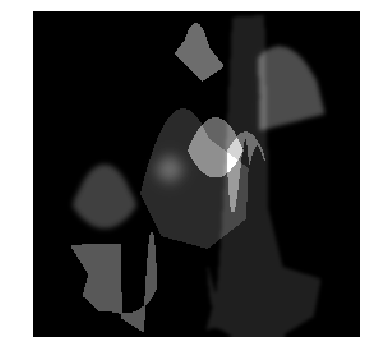

In [12]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(realphantom, cmap="gray")

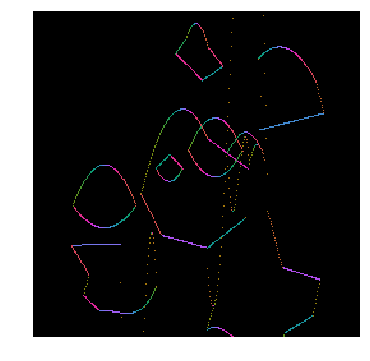

In [13]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

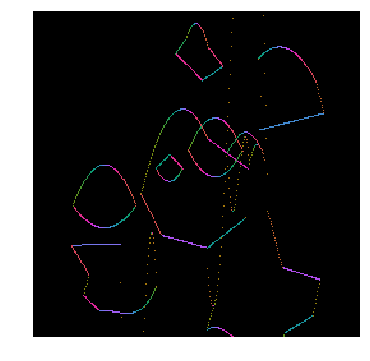

In [14]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_lowd)

### Sinogram of real phantom with WFset generation with full and lowd

In [15]:
from ray_transform.canon_relation import (point_img2sino, class_img2sino, CanRel_img2sino, 
                                         point_sino2img, CanRel_sino2img)

In [16]:
# Create ODL data structures
space = odl.uniform_discr([-int(size/2), -int(size/2)], [int(size/2), int(size/2)], [size, size],
                          dtype='float32')

In [17]:
size = 256
detector_sample = size
impl = 'astra_cuda'

In [18]:
angle_partition_lowd = odl.uniform_partition(0,np.pi,lowd,nodes_on_bdry=True)
angle_partition = odl.uniform_partition(0,np.pi,180,nodes_on_bdry=True)

In [ ]:
n_angles = int((180 - 2 * wedge))
n_angles = math.floor(n_angles)

In [ ]:
wedge_pi = wedge * np.pi/180

In [ ]:
angle_partition_wedge = odl.uniform_partition(wedge_pi, np.pi-wedge_pi,n_angles, nodes_on_bdry=True)

angle_partition = odl.uniform_partition(0,np.pi,180,nodes_on_bdry=True)

In [ ]:
detector_partition = odl.uniform_partition(-int(size/2),int(size/2),
                                               detector_sample,
                                               nodes_on_bdry=True)

In [ ]:
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
geometry_wedge = odl.tomo.Parallel2dGeometry(angle_partition_wedge, detector_partition)


In [ ]:
operator = odl.tomo.RayTransform(space, geometry, impl=impl)
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

In [ ]:
operator_wedge = odl.tomo.RayTransform(space, geometry_wedge, impl=impl)
opnorm_wedge = odl.power_method_opnorm(operator_wedge)
operator_wedge = (1 / opnorm_wedge) * operator_wedge

In [ ]:
# Full dose sinogram
sinogram = np.array(operator(space.element(realphantom)))

In [ ]:
# Low dose sinogram
sinogram_wedge= np.array(operator_wedge(space.element(realphantom)))

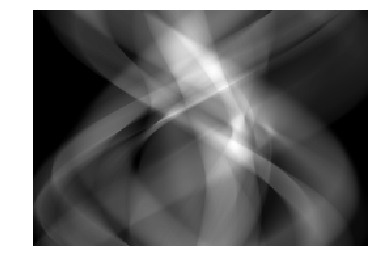

In [ ]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(sinogram , cmap="gray")

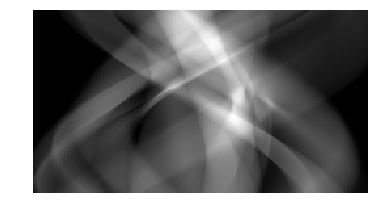

In [ ]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(sinogram_wedge , cmap="gray")

## Learned primal dual

In [ ]:
# Create tensorflow layer from odl operator
odl_op_layer = odl.contrib.tensorflow.as_tensorflow_layer(operator,
                                                          'RayTransform')
odl_op_layer_adjoint = odl.contrib.tensorflow.as_tensorflow_layer(operator.adjoint,
                                                                  'RayTransformAdjoint')

In [ ]:
# User selected paramters
n_data = 5
n_iter = 10
n_primal = 5
n_dual = 5

## Data generator for CT recon

In [ ]:
size = 256
nClasses = 180
lowd = 0
wedge = 40
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)

In [ ]:
batch_size = 5
n_iter = 10
n_primal = 5
n_dual = 5

In [ ]:
def generate_data_CT(validation=False):
    """Generate a set of random data."""
    if validation:
        n_generate = 1
    else: 
        n_generate = batch_size

    y_arr = np.empty((n_generate, operator_wedge.range.shape[0], operator_wedge.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')

    for i in range(n_generate):
        if validation:
            phantom = odl.phantom.shepp_logan(space, True)
        else:
            phantom, _, _,  _ = random_realphantom(size, nRegions, npoints_max, nClasses)
        data = operator_wedge(phantom)
        noisy_data = data + odl.phantom.white_noise(operator_wedge.range) * np.mean(np.abs(data)) * 0.05

        x_true_arr[i, ..., 0] = phantom
        y_arr[i, ..., 0] = noisy_data

    return y_arr, x_true_arr

In [ ]:
y_arr, x_true_arr = generate_data_CT()

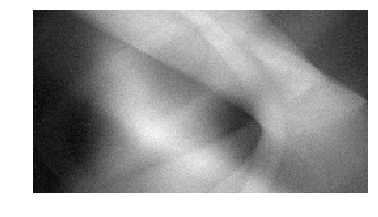

In [ ]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(y_arr[0,:,:,0], cmap="gray")

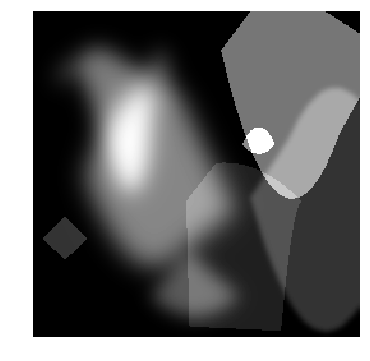

In [ ]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(x_true_arr[0,:,:,0], cmap="gray")

## Learned primal dual model

In [ ]:
# Create tensorflow layer from odl operator
odl_op_layer = odl.contrib.tensorflow.as_tensorflow_layer(operator_wedge,
                                                          'RayTransform')
odl_op_layer_adjoint = odl.contrib.tensorflow.as_tensorflow_layer(operator_wedge.adjoint,
                                                                  'RayTransformAdjoint')

In [ ]:
with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, size, size, 1], name="x_true")
    y_rt = tf.placeholder(tf.float32, shape=[None, operator_wedge.range.shape[0], operator_wedge.range.shape[1], 1], name="y_rt")
    is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

In [ ]:
def apply_conv(x, filters=32):
    return tf.layers.conv2d(x, filters=filters, kernel_size=3, padding='SAME',
                            kernel_initializer=tf.contrib.layers.xavier_initializer(), use_bias=False)

In [ ]:
relu = tf.nn.relu

In [ ]:
with tf.name_scope('tomography'):
    with tf.name_scope('initial_values'):
        primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
        dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)

    for i in range(n_iter):
        with tf.variable_scope('dual_iterate_{}'.format(i)):
            evalop = odl_op_layer(primal[..., 1:2])
            update = tf.concat([dual, evalop, y_rt], axis=-1)

            #update = prelu(apply_conv(update), name='prelu_1')
            #update = prelu(apply_conv(update), name='prelu_2')
            update = relu(apply_conv(update), name='relu_1')
            update = relu(apply_conv(update), name='relu_2')            
            update = apply_conv(update, filters=n_dual)
            dual = dual + update

        with tf.variable_scope('primal_iterate_{}'.format(i)):
            evalop = odl_op_layer_adjoint(dual[..., 0:1])
            update = tf.concat([primal, evalop], axis=-1)

            update = relu(apply_conv(update), name='relu_1')
            update = relu(apply_conv(update), name='relu_2')
            update = apply_conv(update, filters=n_primal)
            primal = primal + update

    x_result = primal[..., 0:1]

### Wavefront set microlocal propagation

In [ ]:
# Get access to the graph
gr = tf.get_default_graph()

In [ ]:
names_variables = [variable.name for variable in tf.global_variables()]

In [ ]:
iterate = 0
conv_layer = 0
dual_layer = True

In [ ]:
## Defining intial values
sinogram_wedge_tf = tf.constant(sinogram_wedge[np.newaxis, :,:, np.newaxis],
                              dtype = tf.float32)
realphantom_tf = tf.constant(realphantom[np.newaxis, :,:, np.newaxis],
                              dtype = tf.float32);

# Initial values of the recon and data
x_true = realphantom_tf 
y_rt = sinogram_lowd_tf;

# Initial value of the primal, dual, update, evalop
primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)
evalop = odl_op_layer(primal[..., 1:2])
update = tf.concat([dual, evalop, y_rt], axis=-1)

# Initial value of WFset
WFset = WFimage_sino_lowd

In [ ]:
radon = operator_lowd
n_batch = update.shape[0]
n_channels =  32
WFset_f = np.repeat(WFset[np.newaxis,:,:],n_batch, axis=0)
WFset_f = np.repeat(WFset_f[:,:,:, np.newaxis],n_channels, axis=3)

In [ ]:
for iterate in range(10)
    name_kernel, conv_relu_1, WFset_ReLUf_1 = ReLU_microlocal(update, radon, WFset_f, gr, iterate, conv_layer, dual_layer)
    WFset = (WFset_ReLUf_1[0,:,:,0])
    WFclasses_sino = [np.array([int(round(WFset[WFpoints_sino[i,1],WFpoints_sino[i,0]]))]) 
                      for i in range(WFpoints_sino.shape[0])]

    ## Upscaling WFpoints_sino_lowd
    WFpoints_sino_up = WFpoints_sino.copy()
    WFpoints_sino_up[:,1] = WFpoints_sino_up[:,1]*180/lowd
    WFclasses_sino_up = WFclasses_sino
    WFpoints_canon, WFclasses_canon = CanRel_sino2img(WFpoints_sino_up, WFclasses_sino_up, size, (180,sinogram_shape[1]) , num_angles = lowd)
    WFpoints_canon = WFpoints_canon.astype(int)
    indxs_inside = ((WFpoints_canon[:,0]<=size)*(WFpoints_canon[:,1]<=size)
               *(WFpoints_canon[:,0]>0)*(WFpoints_canon[:,1]>0))
    WFpoints_canon = WFpoints_canon[indxs_inside]
    WFclases_canon = list(np.array(WFclasses_canon)[indxs_inside])
    WFimage_canon = np.zeros([size,size])
    WFimage_canon = WFupdate(WFpoints_canon, WFclasses_canon, WFimage_canon)

### UNet wavefront set inpainting

In [ ]:
# Import model and custom losses
from models.unet import UNet
from models.losses import CUSTOM_OBJECTS

In [ ]:
# Parameters for the training
learning_rate = 1e-3
loss = 'mae'
batch_size = 50
epoches = 10000

In [ ]:
pretrained = 1
path_to_model_dir = '../WF_inpaint/models/unets_realphantom_WFinpaint/training_5'

In [ ]:
# Data generator
size = 256
nClasses = 180
wedge = 40
train_gen = DataGenerator_realphantom_WFinpaint(batch_size, size, nClasses, lowd)
val_gen = DataGenerator_realphantom_WFinpaint(batch_size, size, nClasses, lowd)

In [ ]:
if pretrained==0:
    # Create a fresh model
    print("Create a fresh model")
    unet = UNet()
    inpainter = unet.create_model( img_shape = (size, size, 1) , loss = loss, learning_rate = learning_rate)
    path_to_training = create_increasing_dir('../models/unets_realphantom_WFinpaint', 'training')
    print("Save training in {}".format(path_to_training))
    path_to_model_dir = path_to_training
    
else: 
    print("Use trained model as initialization:")
    print(path_to_model_dir+"/weights.hdf5")
    inpainter = load_model(path_to_model_dir+"/weights.hdf5",
                       custom_objects=CUSTOM_OBJECTS)
    path_to_training = path_to_model_dir

### Training the joint model

In [ ]:
with tf.name_scope('loss'):
    residual = x_result - x_true
    squared_error = residual ** 2
    loss = 0.5*tf.reduce_mean(squared_error)+0.5*tf.reduce_mean(inpainter(WFimage_canon),WFimage)

In [ ]:
with tf.name_scope('optimizer'):
    # Learning rate
    global_step = tf.Variable(0, trainable=False)
    maximum_steps = 100001
    starter_learning_rate = 1e-3
    learning_rate = cosine_decay(starter_learning_rate,
                                 global_step,
                                 maximum_steps,
                                 name='learning_rate')

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        opt_func = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                          beta2=0.99)

        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), 1)
        optimizer = opt_func.apply_gradients(zip(grads, tvars),
                                             global_step=global_step)

In [ ]:
ckp_name = name+'_ds'+str(detector_sample)+'_wedge'+str(wedge)+'/checkpoints'

In [ ]:
adler.tensorflow.util.default_tensorboard_dir(ckp_name)

'/store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/Joint_CT_WFset_inpaint/checkpoints_ds256_wedge20/checkpoints'

In [ ]:
# Summaries
# tensorboard --logdir=...

with tf.name_scope('summaries'):
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('psnr', -10 * tf.log(loss) / tf.log(10.0))

    tf.summary.image('x_result', x_result)
    tf.summary.image('x_true', x_true)
    tf.summary.image('squared_error', squared_error)
    tf.summary.image('residual', residual)

    merged_summary = tf.summary.merge_all()
    test_summary_writer = tf.summary.FileWriter(adler.tensorflow.util.default_tensorboard_dir(ckp_name) + '/test',
                                                sess.graph)
    train_summary_writer = tf.summary.FileWriter(adler.tensorflow.util.default_tensorboard_dir(ckp_name) + '/train')

In [ ]:
# Initialize all TF variables
sess.run(tf.global_variables_initializer())

In [ ]:
# Generate validation data
y_arr_validate, x_true_arr_validate = generate_data_CT(validation=True)

In [ ]:
# Add op to save and restore
saver = tf.train.Saver()

In [ ]:
if 1:
    saver.restore(sess,
                  adler.tensorflow.util.default_checkpoint_path(ckp_name))

Train the network

In [ ]:
# Train the network
for i in range(0, maximum_steps):
    if i%10 == 0:
        y_arr, x_true_arr = generate_data_CT()

    _, merged_summary_result_train, global_step_result = sess.run([optimizer, merged_summary, global_step],
                              feed_dict={x_true: x_true_arr,
                                         y_rt: y_arr,
                                         is_training: True})
    
    if i>0 and i%10 == 0:
        loss_result, merged_summary_result, global_step_result = sess.run([loss, merged_summary, global_step],
                              feed_dict={x_true: x_true_arr_validate,
                                         y_rt: y_arr_validate,
                                         is_training: False})

        train_summary_writer.add_summary(merged_summary_result_train, global_step_result)
        test_summary_writer.add_summary(merged_summary_result, global_step_result)

        print('iter={}, loss={}'.format(global_step_result, loss_result))

    if i>0 and i%1000 == 0:
        saver.save(sess,
                   adler.tensorflow.util.default_checkpoint_path(ckp_name))

iter=39012, loss=0.006564710754901171
iter=39022, loss=0.006493696942925453
iter=39032, loss=0.00628089252859354
iter=39042, loss=0.006089935079216957
iter=39052, loss=0.006228002719581127
iter=39062, loss=0.006138068623840809
iter=39072, loss=0.00629973690956831
iter=39082, loss=0.006259249523282051
iter=39092, loss=0.006273040547966957
iter=39102, loss=0.006205106154084206
iter=39112, loss=0.00617645587772131
iter=39122, loss=0.006131378933787346
iter=39132, loss=0.006151085719466209
iter=39142, loss=0.0061602238565683365
iter=39152, loss=0.006257812492549419
iter=39162, loss=0.006290004588663578
iter=39172, loss=0.006271878723055124
iter=39182, loss=0.006014942657202482
iter=39192, loss=0.005917376838624477
iter=39202, loss=0.006017561070621014
iter=39212, loss=0.005954340100288391
iter=39222, loss=0.005817890632897615
iter=39232, loss=0.005854737013578415
iter=39242, loss=0.005890253931283951
iter=39252, loss=0.00594533234834671
iter=39262, loss=0.005997614935040474
iter=39272, los

iter=41172, loss=0.005830809473991394
iter=41182, loss=0.005722925066947937
iter=41192, loss=0.0057518864050507545
iter=41202, loss=0.005713679827749729
iter=41212, loss=0.00646955706179142
iter=41222, loss=0.006836123764514923
iter=41232, loss=0.006312662735581398
iter=41242, loss=0.006349213887006044
iter=41252, loss=0.006139333359897137
iter=41262, loss=0.006087142508476973
iter=41272, loss=0.006116811186075211
iter=41282, loss=0.006132159382104874
iter=41292, loss=0.006309079006314278
iter=41302, loss=0.006276481784880161
iter=41312, loss=0.006262781098484993
iter=41322, loss=0.0061576394364237785
iter=41332, loss=0.005919783376157284
iter=41342, loss=0.0059692393988370895
iter=41352, loss=0.0058343117125332355
iter=41362, loss=0.005894322879612446
iter=41372, loss=0.005851055029779673
iter=41382, loss=0.005761974025517702
iter=41392, loss=0.005658669862896204
iter=41402, loss=0.005715962033718824
iter=41412, loss=0.005788231268525124
iter=41422, loss=0.0057258810847997665
iter=414